In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [2]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.19MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 263kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 296kB/s]


## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

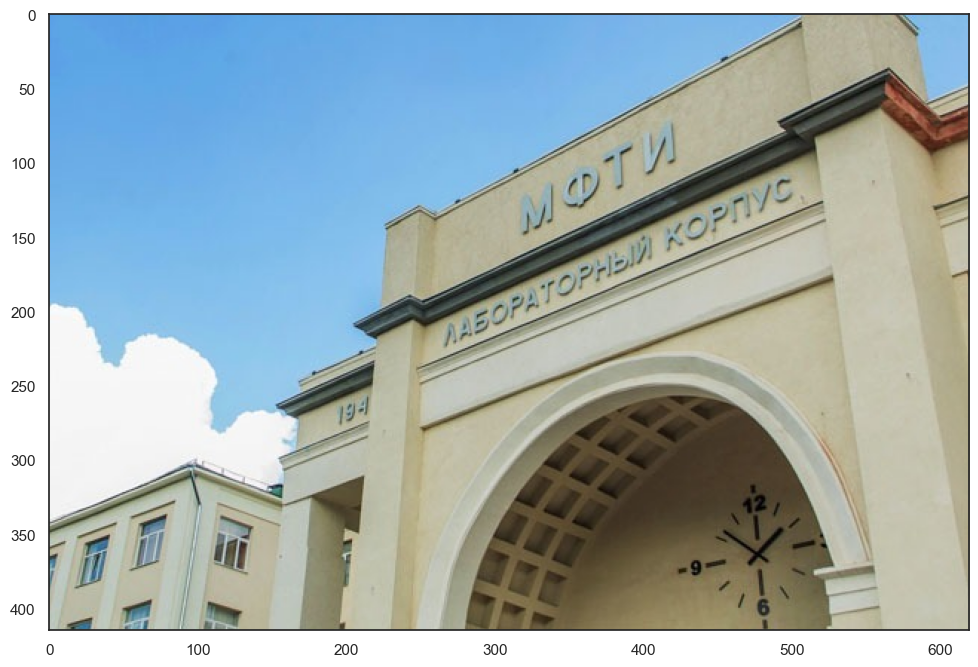

In [3]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [22]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [10, -20, 10],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-7.669271..8.1901045].


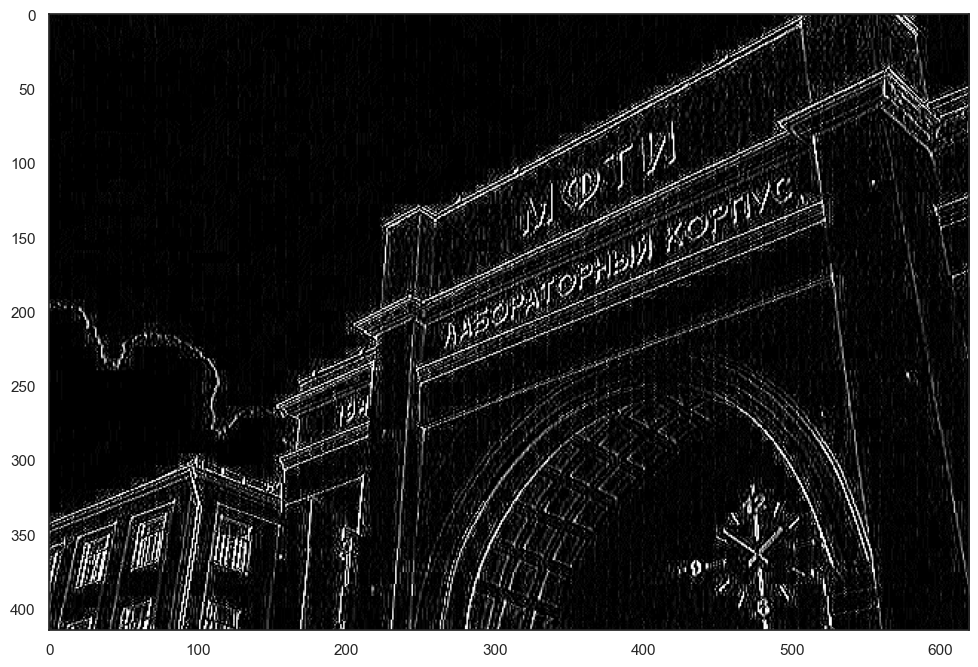

In [23]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие Е

2) Увеличение резкости Д

3) Тождественное преобразование А

4) Выделение вертикальных границ В

5) Выделение горизонтальных границ Б

6) Выделение границ Г

**Ответ:**
1) Е
2) Д
3) А
4) В
5) Б
6) Г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [26]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
    
for epoch in range(max_epochs):
    for k in ["train", "valid"]:
        epoch_correct = 0
        epoch_all = 0
        
        if k == "train":
            model.train()
        else:
            model.eval()
        
        for x_batch, y_batch in loaders[k]:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            if k == "train":
                model.train()
                optimizer.zero_grad()
            
            with torch.set_grad_enabled(k == "train"):
                outp = model(x_batch)
                loss = criterion(outp, y_batch)
                
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum().item()
            all = y_batch.size(0)
            epoch_correct += correct
            epoch_all += all
            
            if k == "train":
                loss.backward()
                optimizer.step()
        
        epoch_acc = epoch_correct / epoch_all
        accuracy[k].append(epoch_acc)
        print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all:.4f}")

Epoch: 1
Loader: train. Accuracy: 0.9128
Epoch: 1
Loader: valid. Accuracy: 0.9768
Epoch: 2
Loader: train. Accuracy: 0.9754
Epoch: 2
Loader: valid. Accuracy: 0.9799
Epoch: 3
Loader: train. Accuracy: 0.9831
Epoch: 3
Loader: valid. Accuracy: 0.9840
Epoch: 4
Loader: train. Accuracy: 0.9865
Epoch: 4
Loader: valid. Accuracy: 0.9857
Epoch: 5
Loader: train. Accuracy: 0.9889
Epoch: 5
Loader: valid. Accuracy: 0.9890
Epoch: 6
Loader: train. Accuracy: 0.9910
Epoch: 6
Loader: valid. Accuracy: 0.9882
Epoch: 7
Loader: train. Accuracy: 0.9920
Epoch: 7
Loader: valid. Accuracy: 0.9880
Epoch: 8
Loader: train. Accuracy: 0.9931
Epoch: 8
Loader: valid. Accuracy: 0.9874
Epoch: 9
Loader: train. Accuracy: 0.9942
Epoch: 9
Loader: valid. Accuracy: 0.9848
Epoch: 10
Loader: train. Accuracy: 0.9949
Epoch: 10
Loader: valid. Accuracy: 0.9886


### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [27]:
class Identical(nn.Module):
    def forward(self, x):
        return x


def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, 128),
        activation(),
        nn.Linear(128, 128),
        activation(),
        nn.Linear(128, 10)
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    max_epochs = 10
    accuracy = {"train": [], "valid": []}

    for epoch in range(max_epochs):
        for k in ["train", "valid"]:
            epoch_correct = 0
            epoch_all = 0

            if k == "train":
                model.train()
            else:
                model.eval()

            for x_batch, y_batch in loaders[k]:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                if k == "train":
                    model.train()
                    optimizer.zero_grad()

                with torch.set_grad_enabled(k == "train"):
                    outp = model(x_batch)
                    loss = criterion(outp, y_batch)

                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum().item()
                all = y_batch.size(0)
                epoch_correct += correct
                epoch_all += all

                if k == "train":
                    loss.backward()
                    optimizer.step()

            epoch_acc = epoch_correct / epoch_all
            accuracy[k].append(epoch_acc)
            print(f"Epoch: {epoch + 1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")

    return accuracy


elu_accuracy = test_activation_function(nn.ELU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)
relu_accuracy = test_activation_function(nn.ReLU)

Epoch: 1
Loader: train. Accuracy: 0.9032166666666667
Epoch: 1
Loader: valid. Accuracy: 0.9383
Epoch: 2
Loader: train. Accuracy: 0.9573166666666667
Epoch: 2
Loader: valid. Accuracy: 0.9586
Epoch: 3
Loader: train. Accuracy: 0.9674333333333334
Epoch: 3
Loader: valid. Accuracy: 0.967
Epoch: 4
Loader: train. Accuracy: 0.9727666666666667
Epoch: 4
Loader: valid. Accuracy: 0.9753
Epoch: 5
Loader: train. Accuracy: 0.9775833333333334
Epoch: 5
Loader: valid. Accuracy: 0.972
Epoch: 6
Loader: train. Accuracy: 0.9802833333333333
Epoch: 6
Loader: valid. Accuracy: 0.9685
Epoch: 7
Loader: train. Accuracy: 0.9821
Epoch: 7
Loader: valid. Accuracy: 0.9669
Epoch: 8
Loader: train. Accuracy: 0.98385
Epoch: 8
Loader: valid. Accuracy: 0.9788
Epoch: 9
Loader: train. Accuracy: 0.9859833333333333
Epoch: 9
Loader: valid. Accuracy: 0.9734
Epoch: 10
Loader: train. Accuracy: 0.9880666666666666
Epoch: 10
Loader: valid. Accuracy: 0.9723
Epoch: 1
Loader: train. Accuracy: 0.8939666666666667
Epoch: 1
Loader: valid. Accura

In [28]:
lenet_accuracy = accuracy["valid"]

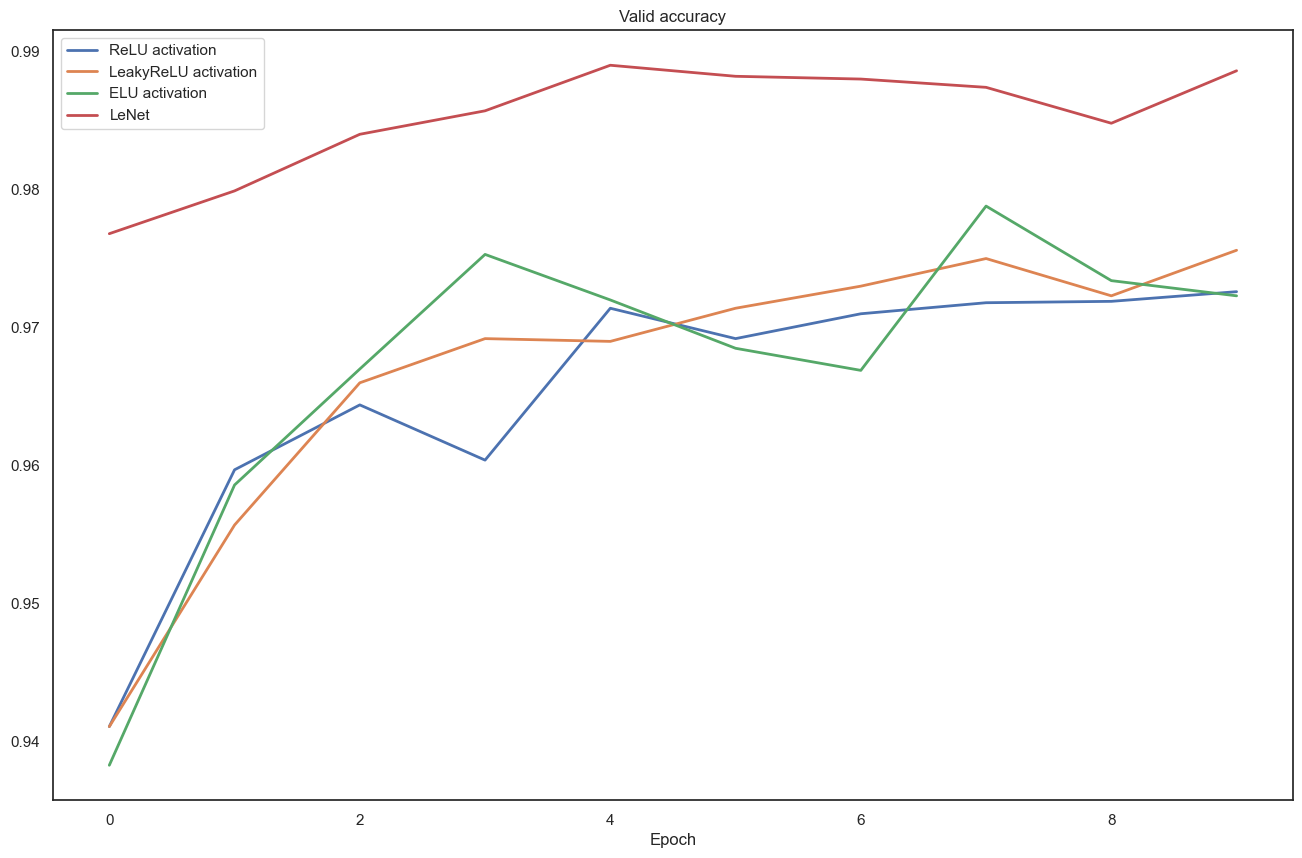

In [30]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy["valid"], label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy["valid"], label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy["valid"], label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.99